In [1]:
from qgis.core import *
import pandas as pd
import numpy as np

In [2]:
import sys
import os
from osgeo import ogr
from qgis.core import (
     QgsApplication,
     QgsProcessingFeedback,
     QgsVectorLayer
)
from qgis.analysis import QgsNativeAlgorithms

In [3]:
QgsApplication.setPrefixPath(r'C:\OSGeo4W\apps\qgis', True)
qgs = QgsApplication([], False)
qgs.initQgis()
sys.path.append(r'C:\OSGeo4W\apps\qgis\python\plugins')

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.ion()
import xlwings as xw
from time import time
import seaborn as sns
import math
import statistics
import scipy.stats

import processing
from processing.core.Processing import Processing
Processing.initialize()
QgsApplication.processingRegistry().addProvider(QgsNativeAlgorithms())
#for alg in QgsApplication.processingRegistry().algorithms():
#        print(alg.id(), "--->", alg.displayName())

C:\OSGeo4W\apps\Python39\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


False

In [5]:
# living_houses_pts = QgsVectorLayer(r"https://github.com/echo-golf-oscar-romeo/kindergarten_accessibility/blob/c66a8368b58ad126afb051cc72958379104b80fb/living_houses_pts.geojson")
# kindergarten_pts = QgsVectorLayer(r"https://github.com/echo-golf-oscar-romeo/kindergarten_accessibility/blob/5f8e3b92d19082e424ded1010d9ca836e44ba49c/kindergarten_pts.geojson")

living_houses_pts = QgsVectorLayer(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\resid.geojson")
kindergarten_pts = QgsVectorLayer(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\kindergarten_pts.geojson")

In [6]:
from qgis.core import QgsProcessing
from qgis.core import QgsProcessingAlgorithm
from qgis.core import QgsProcessingMultiStepFeedback
from qgis.core import QgsProcessingParameterVectorLayer
from qgis.core import QgsProcessingParameterNumber
from qgis.core import QgsProcessingParameterFileDestination
from qgis.core import QgsProcessingParameterFeatureSink
import processing


class Kindergarten_egor(QgsProcessingAlgorithm):

    def initAlgorithm(self, config=None):
        self.addParameter(QgsProcessingParameterVectorLayer('livinghousescentoids', 'living_houses_centoids', types=[QgsProcessing.TypeVectorPoint], defaultValue=living_houses_pts))
        self.addParameter(QgsProcessingParameterVectorLayer('kindergartencentroids', 'kindergarten_centroids', types=[QgsProcessing.TypeVectorPoint], defaultValue=kindergarten_pts))
        self.addParameter(QgsProcessingParameterNumber('bufferradius', 'buffer_radius', type=QgsProcessingParameterNumber.Integer, minValue=1, defaultValue=300))
        self.addParameter(QgsProcessingParameterFileDestination('Spreadsheet', 'spreadsheet', fileFilter='Microsoft Excel (*.xlsx);;Open Document Spreadsheet (*.ods)', createByDefault=True, defaultValue=None))
        self.addParameter(QgsProcessingParameterFeatureSink('Intersection_raw', 'intersection_raw', optional=True, type=QgsProcessing.TypeVectorAnyGeometry, createByDefault=True, defaultValue=None))

    def processAlgorithm(self, parameters, context, model_feedback):
        # Use a multi-step feedback, so that individual child algorithm progress reports are adjusted for the
        # overall progress through the model
        feedback = QgsProcessingMultiStepFeedback(3, model_feedback)
        results = {}
        outputs = {}

        # Buffer
        alg_params = {
            'DISSOLVE': False,
            'DISTANCE': parameters['bufferradius'],
            'END_CAP_STYLE': 0,  # Round
            'INPUT': parameters['kindergartencentroids'],
            'JOIN_STYLE': 0,  # Round
            'MITER_LIMIT': 2,
            'SEGMENTS': 15,
            'OUTPUT': QgsProcessing.TEMPORARY_OUTPUT
        }
        outputs['Buffer'] = processing.run('native:buffer', alg_params, context=context, feedback=feedback, is_child_algorithm=True)

        feedback.setCurrentStep(1)
        if feedback.isCanceled():
            return {}

        # Join attributes by location
        alg_params = {
            'DISCARD_NONMATCHING': False,
            'INPUT': outputs['Buffer']['OUTPUT'],
            'JOIN': parameters['livinghousescentoids'],
            'JOIN_FIELDS': [''],
            'METHOD': 0,  # Create separate feature for each matching feature (one-to-many)
            'PREDICATE': [1],  # contains
            'PREFIX': 'j_',
            'OUTPUT': parameters['Intersection_raw']
        }
        outputs['JoinAttributesByLocation'] = processing.run('native:joinattributesbylocation', alg_params, context=context, feedback=feedback, is_child_algorithm=True)
        results['Intersection_raw'] = outputs['JoinAttributesByLocation']['OUTPUT']

        feedback.setCurrentStep(2)
        if feedback.isCanceled():
            return {}

        # Export to spreadsheet
        alg_params = {
            'FORMATTED_VALUES': False,
            'LAYERS': outputs['JoinAttributesByLocation']['OUTPUT'],
            'OVERWRITE': True,
            'USE_ALIAS': False,
            'OUTPUT': parameters['Spreadsheet']
        }
        outputs['ExportToSpreadsheet'] = processing.run('native:exporttospreadsheet', alg_params, context=context, feedback=feedback, is_child_algorithm=True)
        results['Spreadsheet'] = outputs['ExportToSpreadsheet']['OUTPUT']
        print(results['Spreadsheet'])
        return results

    def name(self):
        return 'kindergarten_egor'

    def displayName(self):
        return 'kindergarten_egor'

    def group(self):
        return 'egor'

    def groupId(self):
        return 'egor'

    def createInstance(self):
        return Kindergarten_egor()

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000100.xlsx


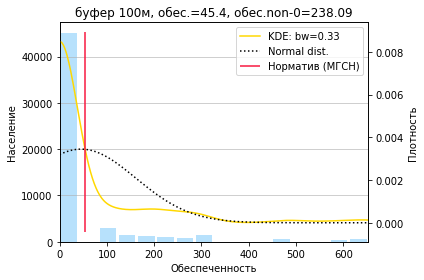

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000105.xlsx


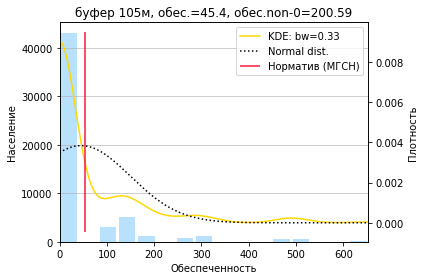

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000110.xlsx


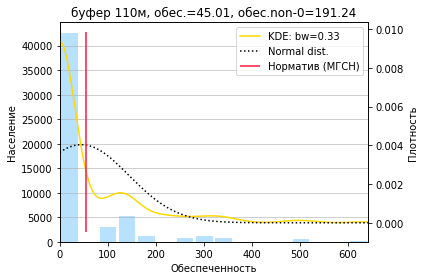

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000115.xlsx


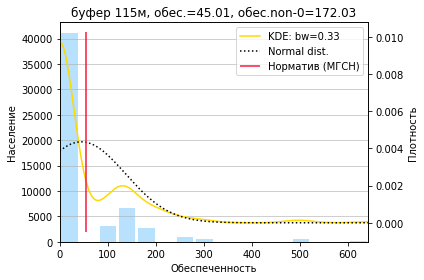

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000120.xlsx


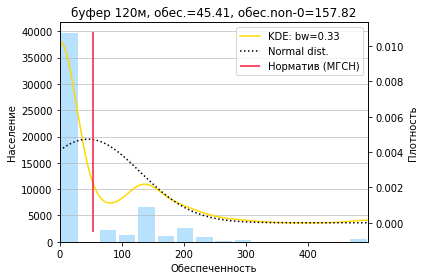

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000125.xlsx


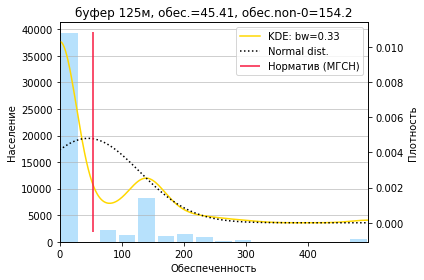

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000130.xlsx


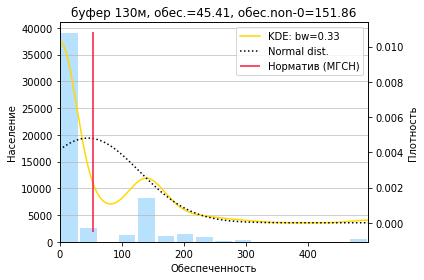

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000135.xlsx


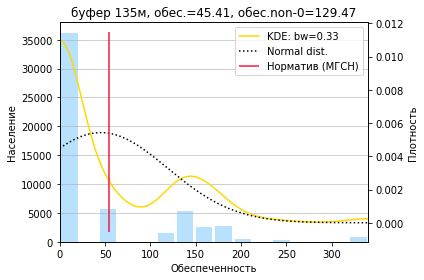

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000140.xlsx


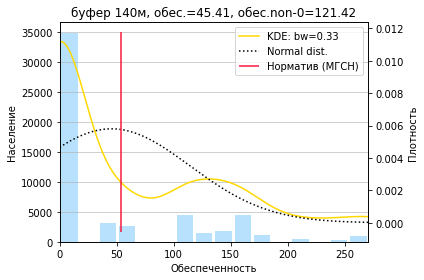

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000145.xlsx


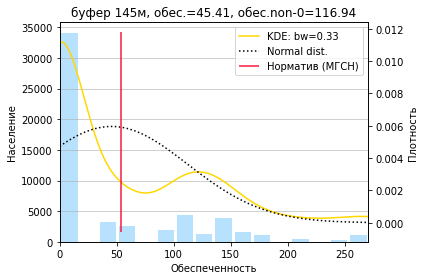

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000150.xlsx


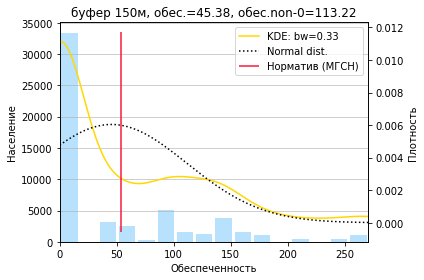

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000155.xlsx


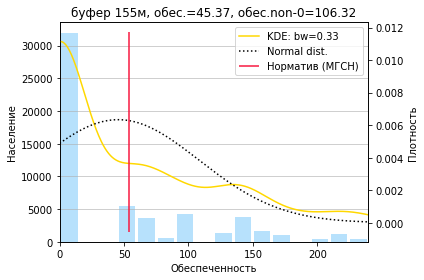

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000160.xlsx


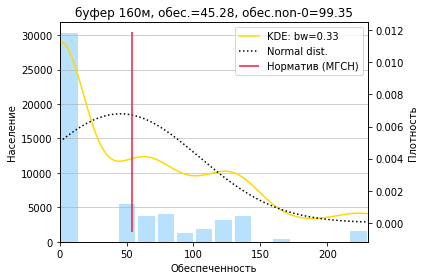

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000165.xlsx


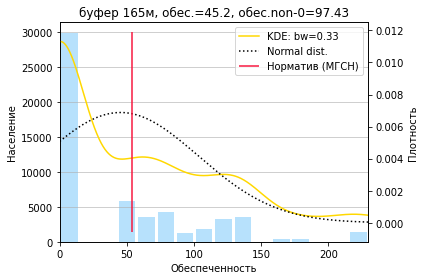

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000170.xlsx


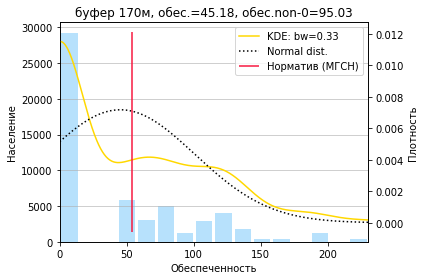

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000175.xlsx


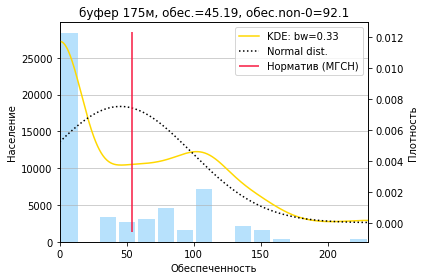

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000180.xlsx


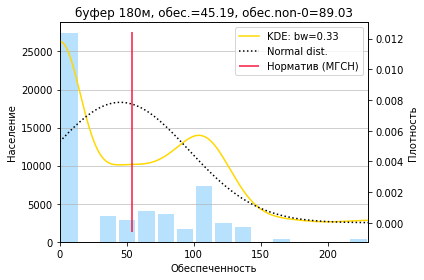

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000185.xlsx


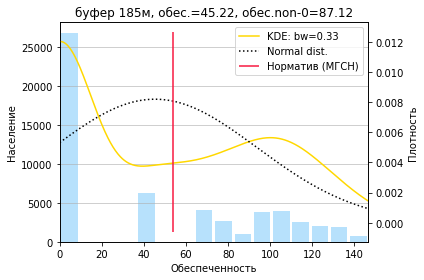

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000190.xlsx


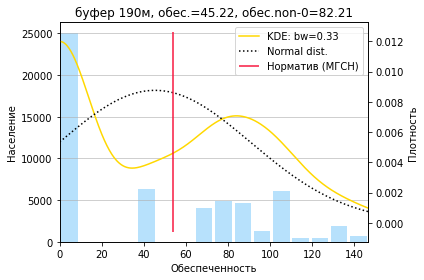

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000195.xlsx


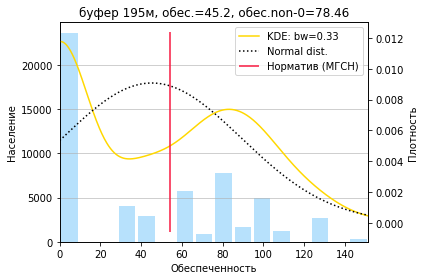

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000200.xlsx


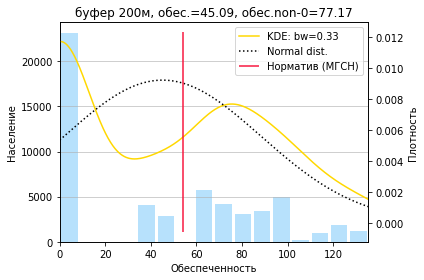

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000205.xlsx


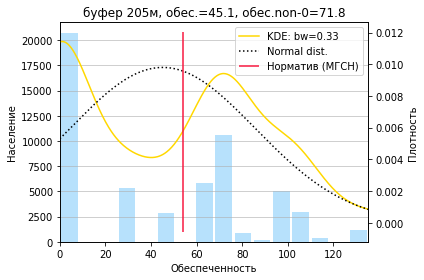

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000210.xlsx


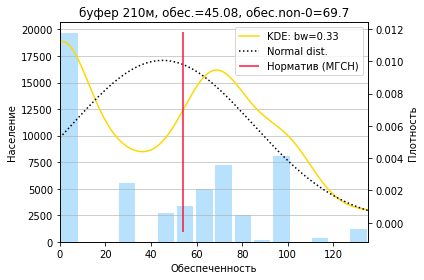

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000215.xlsx


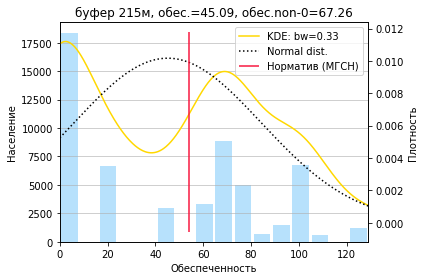

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000220.xlsx


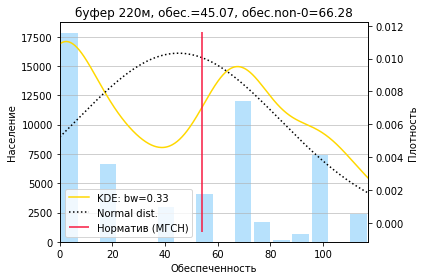

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000225.xlsx


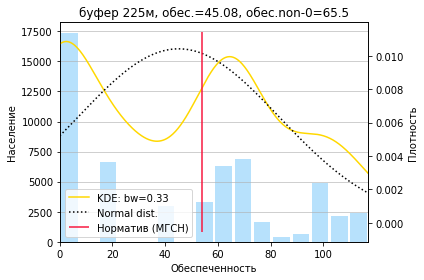

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000230.xlsx


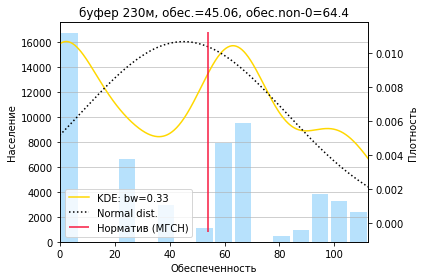

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000235.xlsx


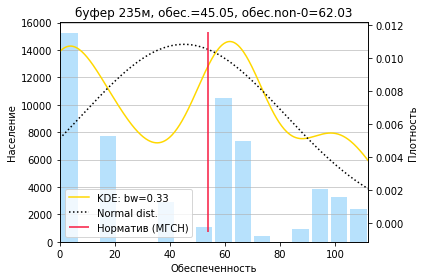

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000240.xlsx


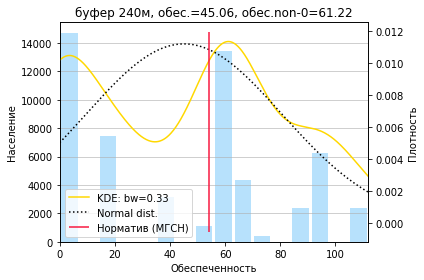

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000245.xlsx


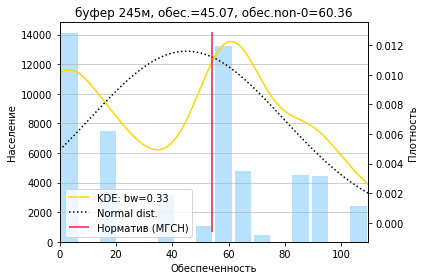

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000250.xlsx


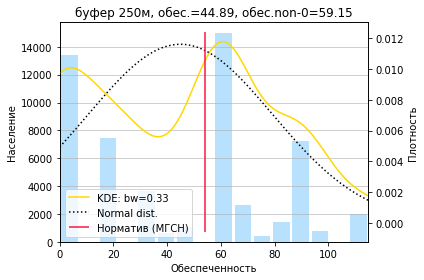

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000255.xlsx


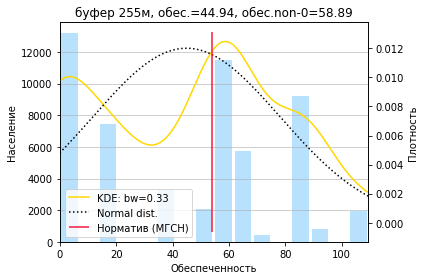

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000260.xlsx


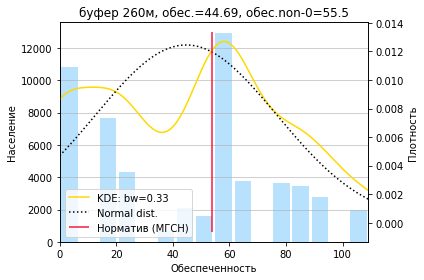

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000265.xlsx


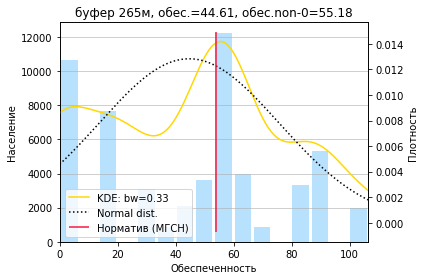

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000270.xlsx


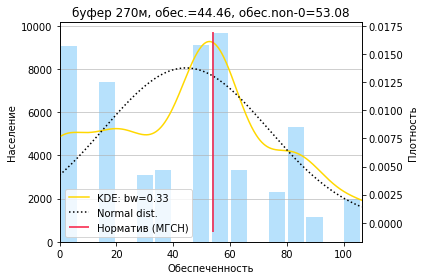

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000275.xlsx


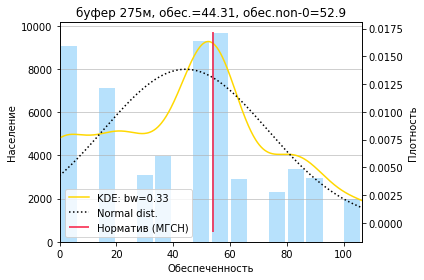

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000280.xlsx


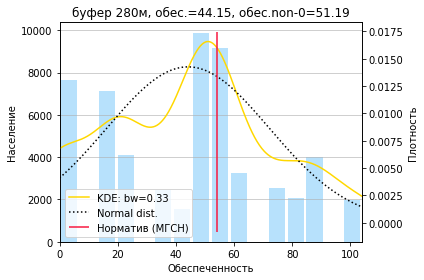

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000285.xlsx


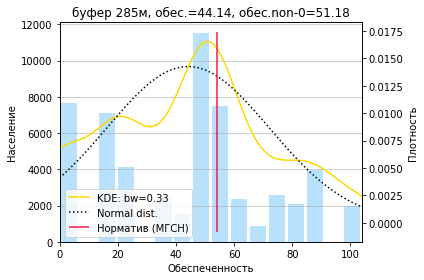

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000290.xlsx


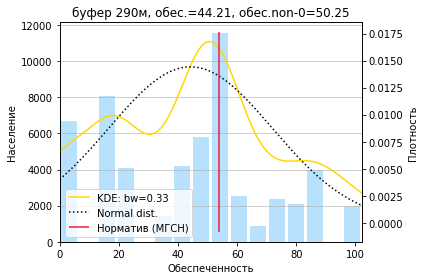

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000295.xlsx


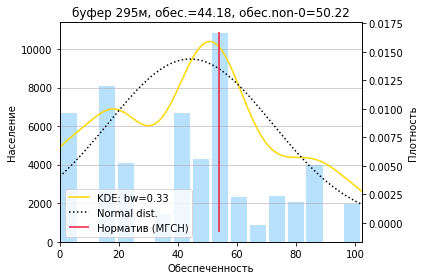

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000300.xlsx


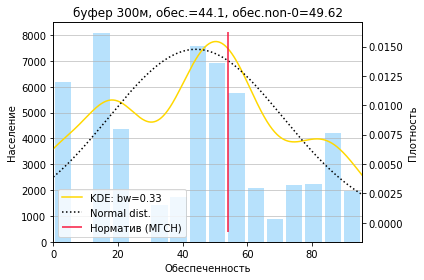

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000305.xlsx


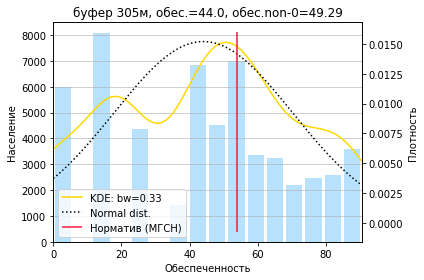

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000310.xlsx


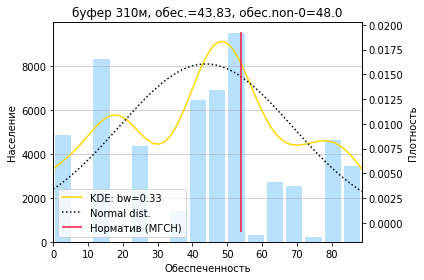

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000315.xlsx


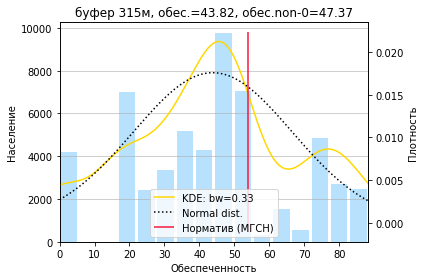

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000320.xlsx


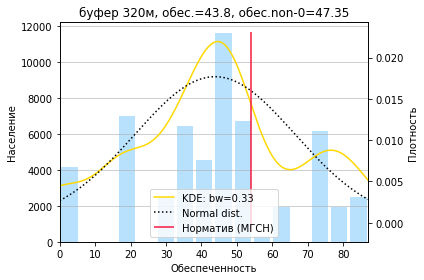

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000325.xlsx


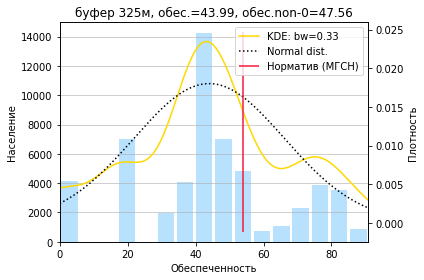

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000330.xlsx


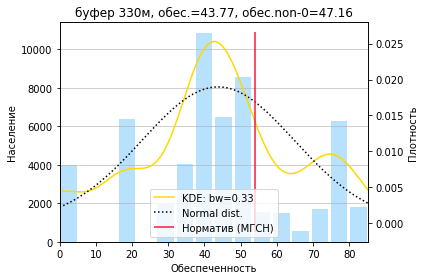

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000335.xlsx


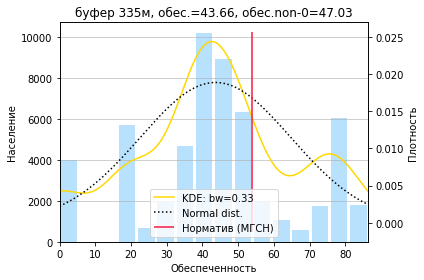

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000340.xlsx


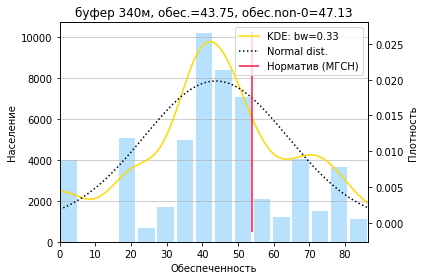

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000345.xlsx


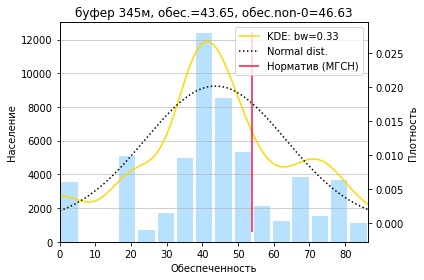

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000350.xlsx


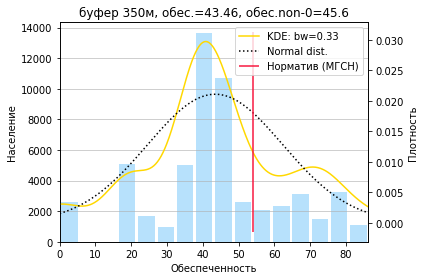

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000355.xlsx


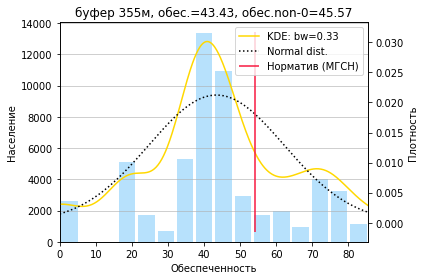

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000360.xlsx


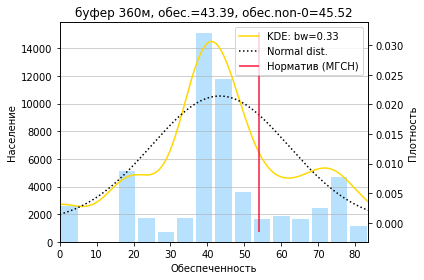

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000365.xlsx


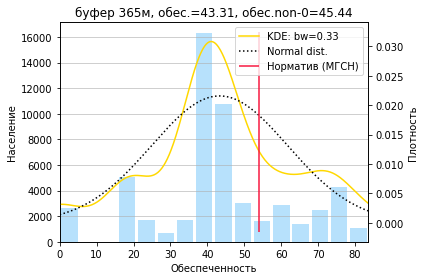

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000370.xlsx


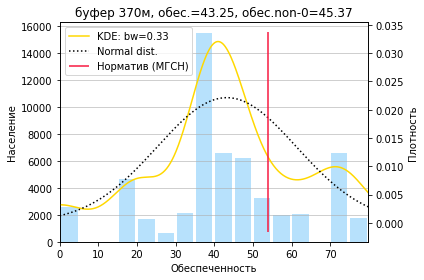

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000375.xlsx


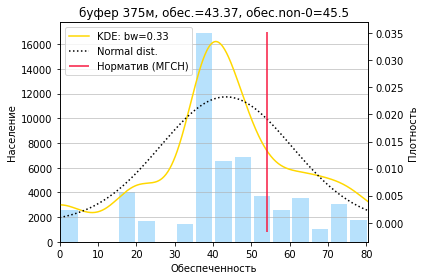

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000380.xlsx


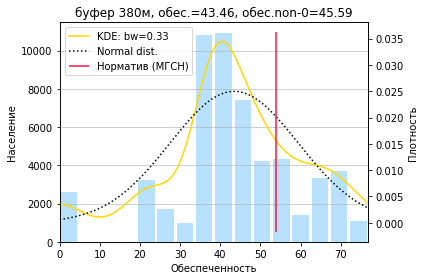

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000385.xlsx


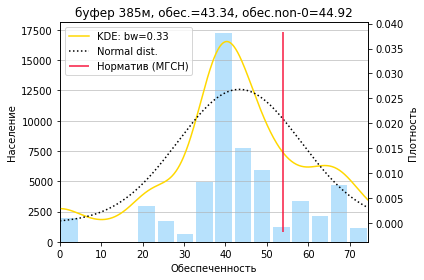

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000390.xlsx


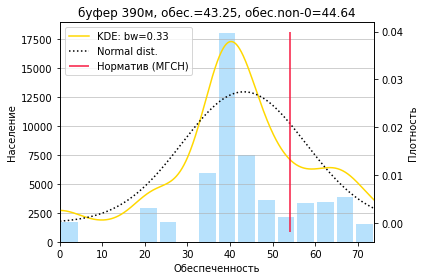

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000395.xlsx


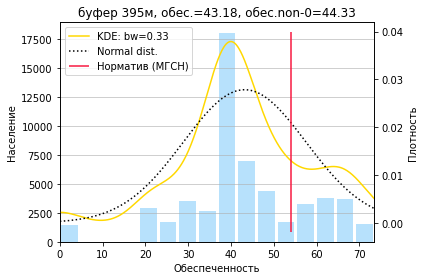

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000400.xlsx


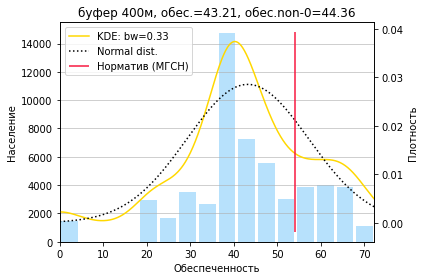

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000405.xlsx


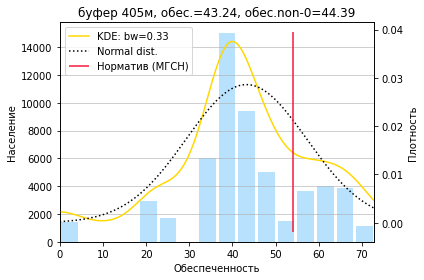

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000410.xlsx


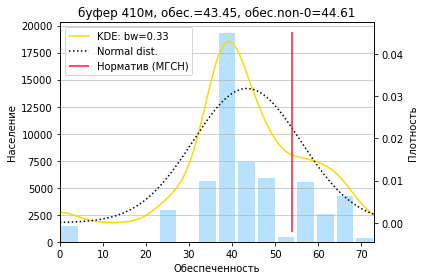

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000415.xlsx


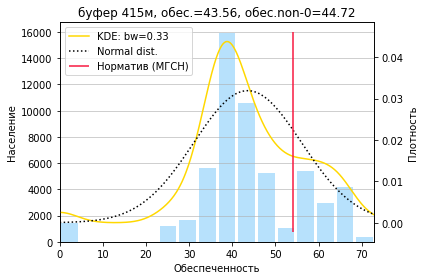

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000420.xlsx


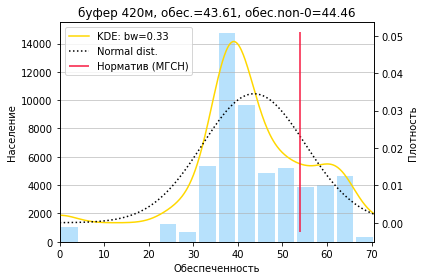

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000425.xlsx


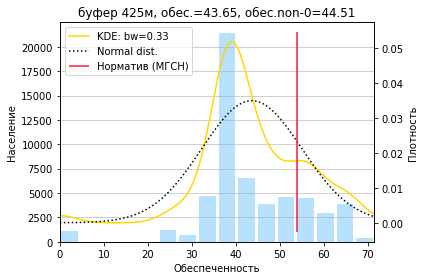

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000430.xlsx


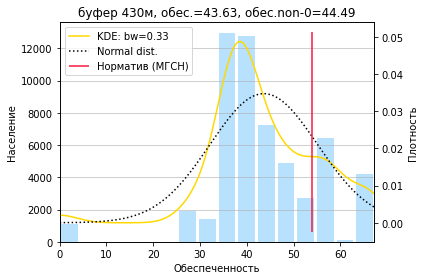

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000435.xlsx


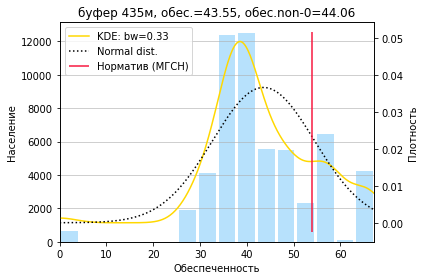

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000440.xlsx


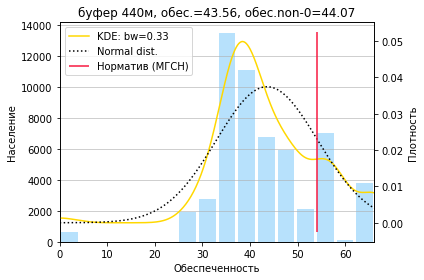

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000445.xlsx


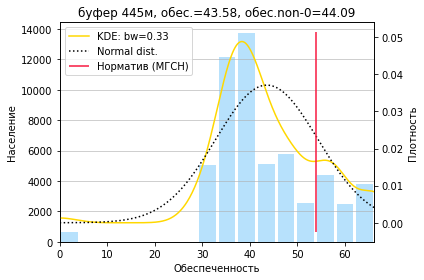

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000450.xlsx


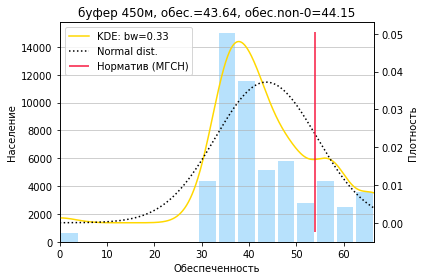

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000455.xlsx


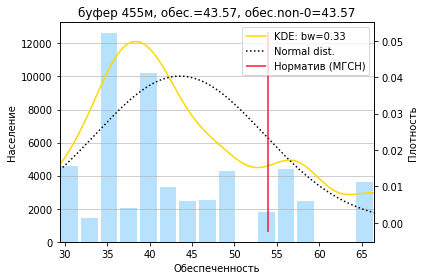

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000460.xlsx


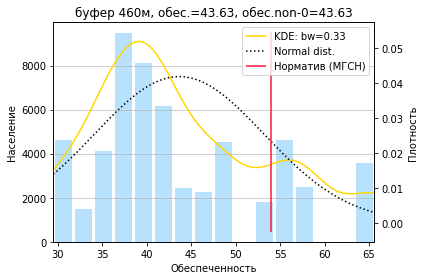

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000465.xlsx


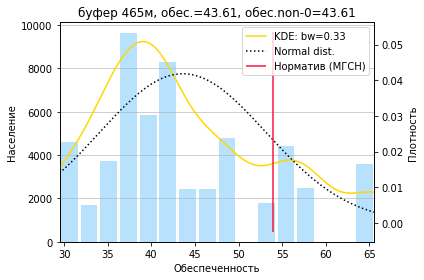

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000470.xlsx


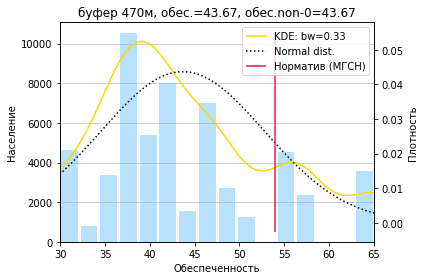

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000475.xlsx


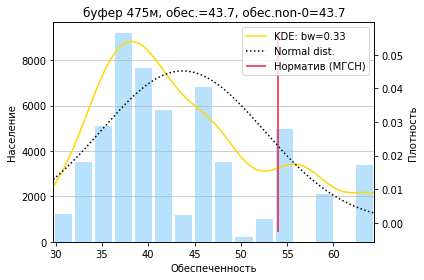

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000480.xlsx


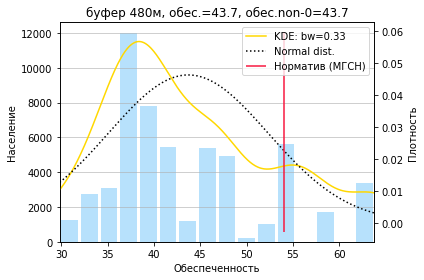

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000485.xlsx


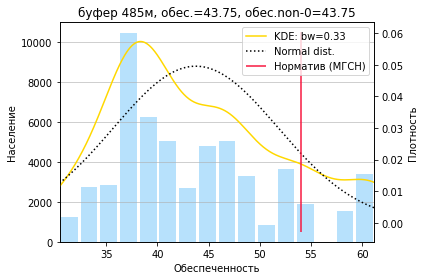

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000490.xlsx


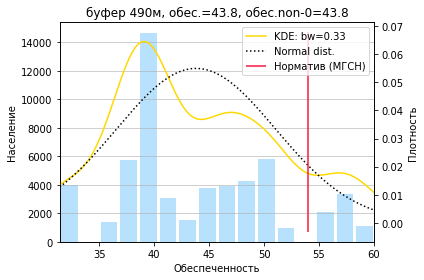

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000495.xlsx


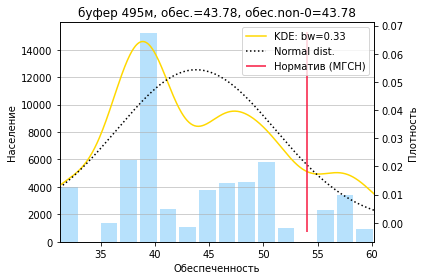

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000500.xlsx


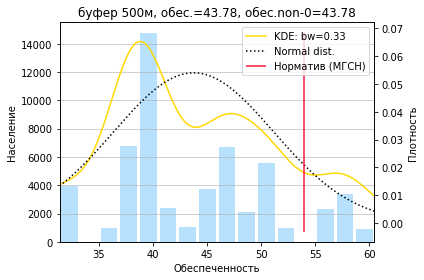

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000505.xlsx


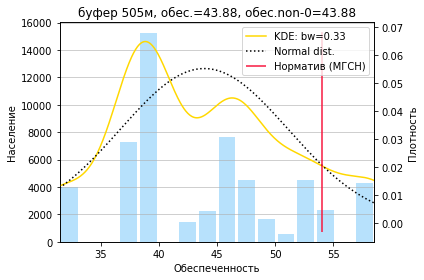

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000510.xlsx


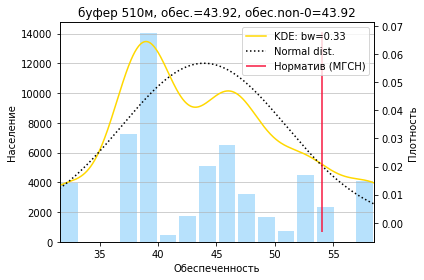

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000515.xlsx


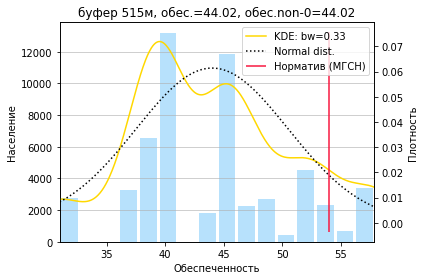

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000520.xlsx


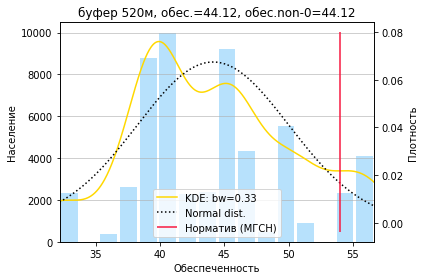

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000525.xlsx


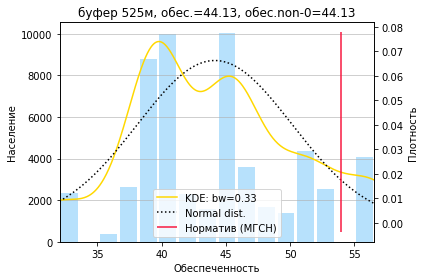

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000530.xlsx


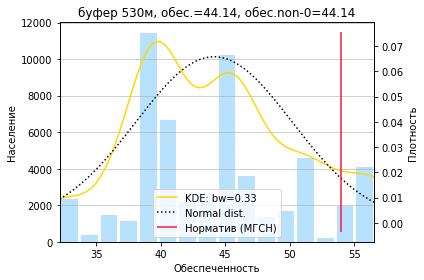

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000535.xlsx


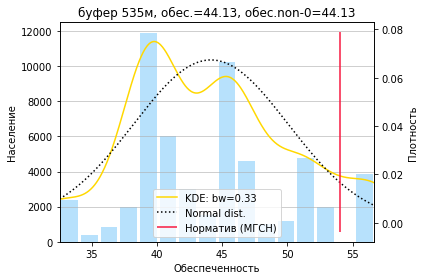

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000540.xlsx


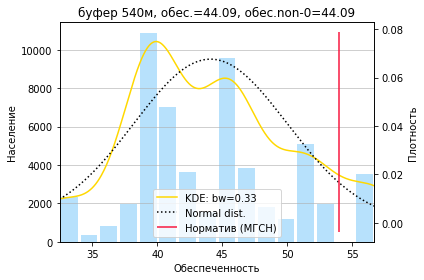

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000545.xlsx


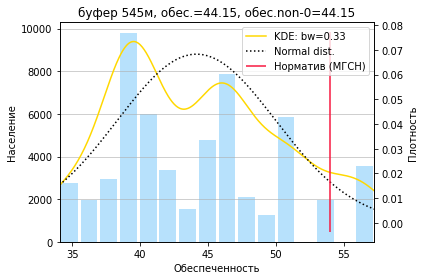

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000550.xlsx


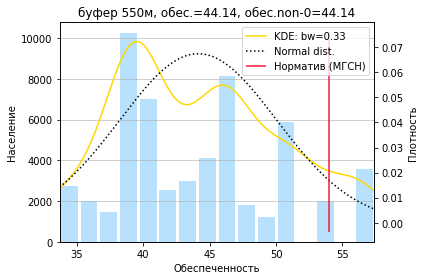

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000555.xlsx


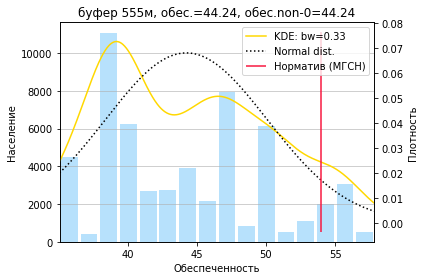

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000560.xlsx


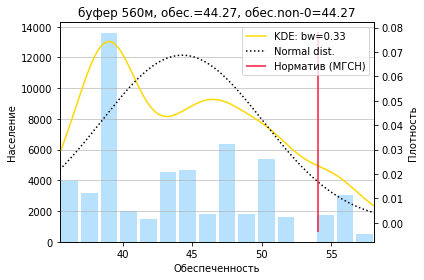

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000565.xlsx


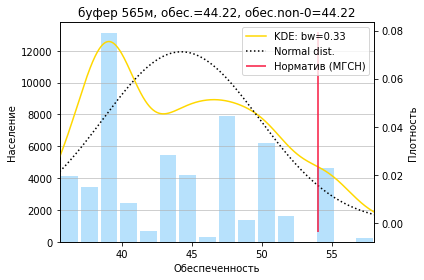

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000570.xlsx


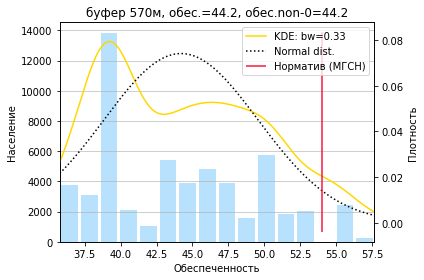

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000575.xlsx


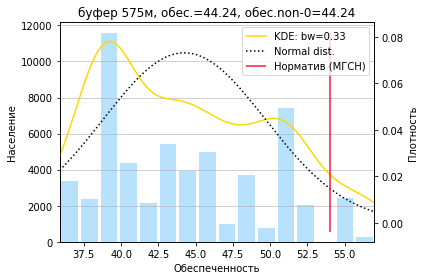

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000580.xlsx


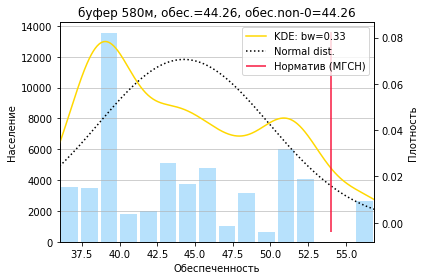

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000585.xlsx


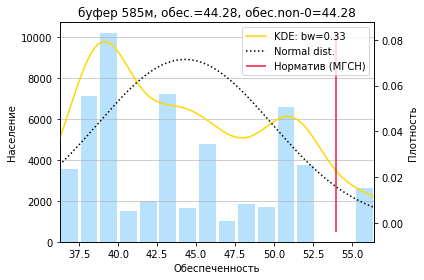

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000590.xlsx


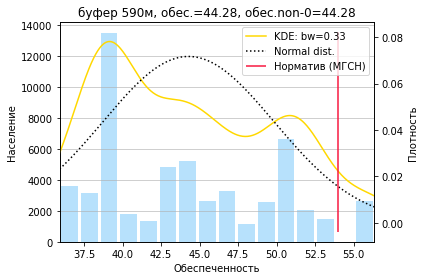

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000595.xlsx


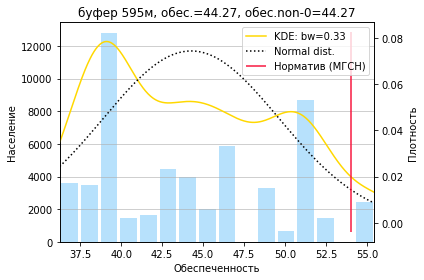

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000600.xlsx


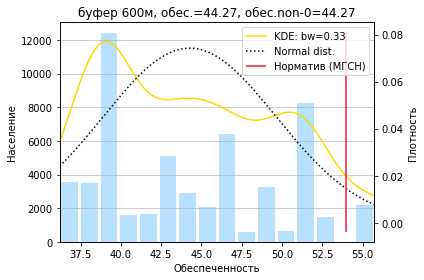

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000605.xlsx


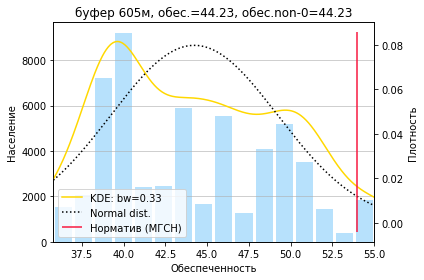

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000610.xlsx


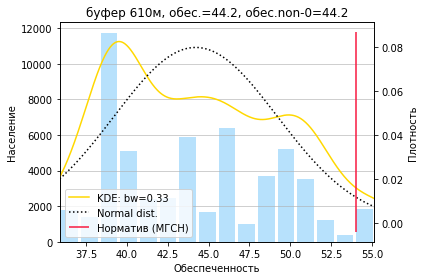

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000615.xlsx


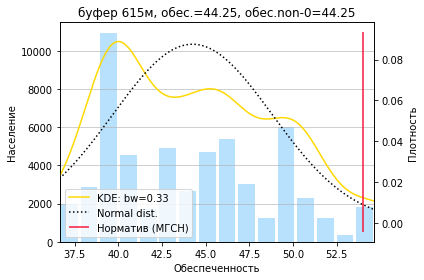

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000620.xlsx


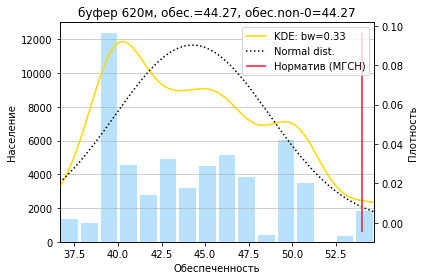

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000625.xlsx


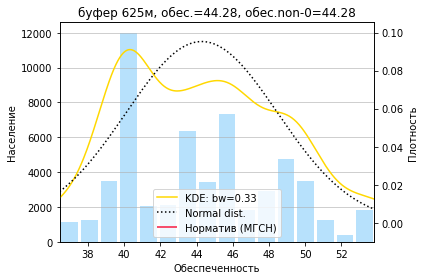

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000630.xlsx


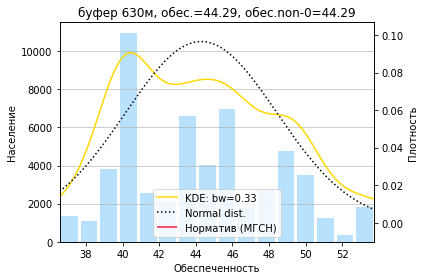

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000635.xlsx


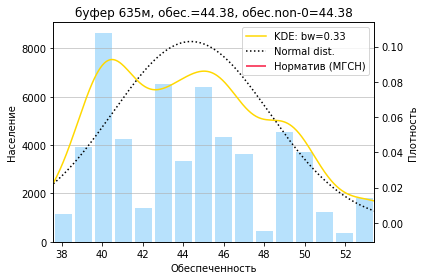

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000640.xlsx


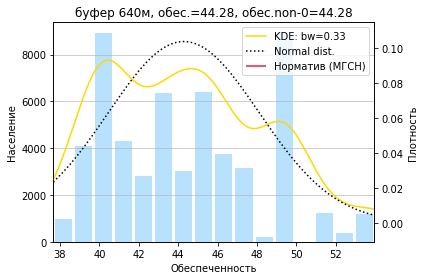

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000645.xlsx


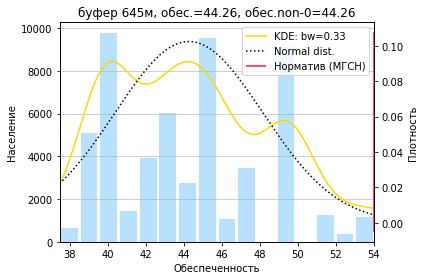

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000650.xlsx


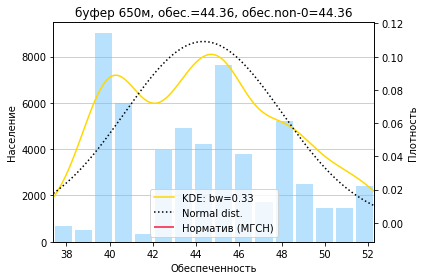

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000655.xlsx


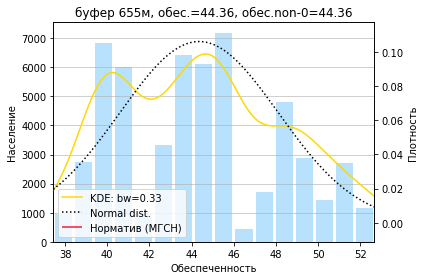

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000660.xlsx


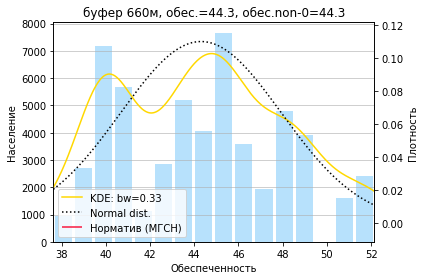

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000665.xlsx


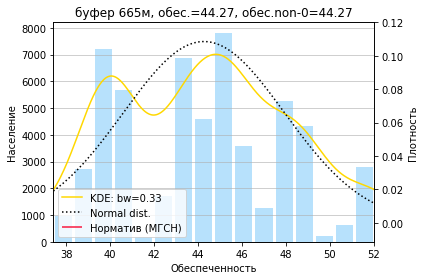

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000670.xlsx


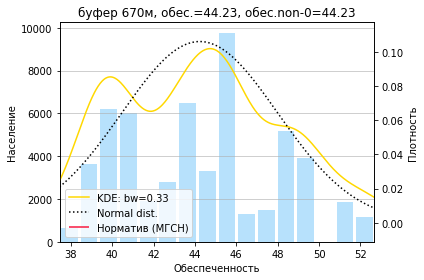

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000675.xlsx


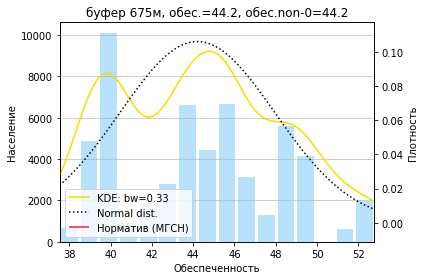

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000680.xlsx


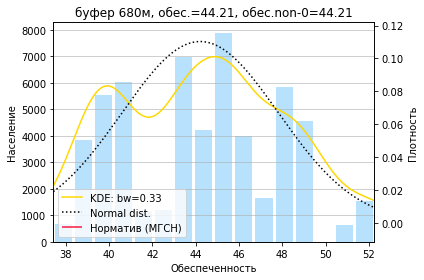

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000685.xlsx


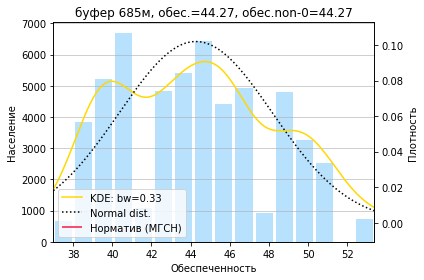

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000690.xlsx


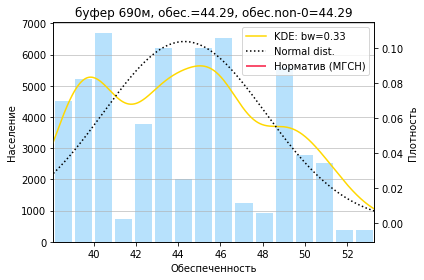

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000695.xlsx


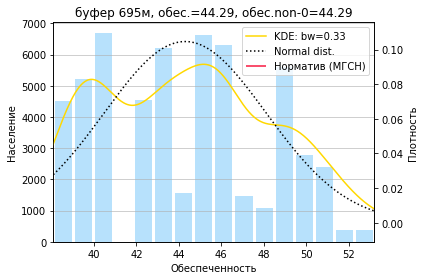

C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000700.xlsx


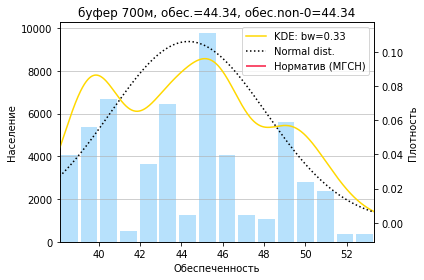

514.3749341964722


In [9]:
hello = Kindergarten_egor()
t0 = time()
for buffer_radius in range(100,701,5):
    intersection_raw = r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000%s.geojson" % buffer_radius
    table = r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000%s.xlsx" % buffer_radius
    parameters = {
        'bufferradius': buffer_radius,
        'kindergartencentroids': kindergarten_pts,
        'livinghousescentoids': living_houses_pts,
        'Intersection_raw': intersection_raw,
        'Spreadsheet': table
    }
    context = QgsProcessingContext()
    feedback = QgsProcessingFeedback()
    hello.processAlgorithm(parameters, context=context, model_feedback=feedback)
    
    # very bad moving data from excel to github excel file
    
    brand_new_data = pd.read_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\trash\trash_000%s.xlsx" % buffer_radius)
    #brand_new_data.to_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx", sheet_name = 'intersection_raw')
    
    xb = xw.Book(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx")
    sheet = xb.sheets("intersection_raw")
    sheet.clear()
    sheet.range("A1", "K1000").value = brand_new_data
    xb.save()

    data = pd.read_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx", sheet_name = 'Bar_chart', engine="openpyxl")
    data_bar_chart = data[["Mean", "Population"]].loc[:8]
    
    endowment = round(pd.read_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx", sheet_name = '10', engine="openpyxl")["Unnamed: 1"].loc[0], 2)
    endowment_1 = round(pd.read_excel(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\Calculator.xlsx", sheet_name = '10', engine="openpyxl")["Unnamed: 1"].loc[2], 2)
    
    df = data[["Обеспеченность","Население","houses id"]]

    df_new = df
    for i in range(len(df)):
        index_to_copy = i
        number_of_extra_copies = df["Население"][i]
        df_new = pd.concat([df_new,
                    pd.DataFrame(np.repeat(df.iloc[[index_to_copy]].values,
                                            number_of_extra_copies,
                                            axis=0),
                                columns=df.columns)]).sort_values(by="houses id").drop(columns='houses id').reset_index(drop=True)
    x = df_new["Обеспеченность"].dropna()
    
    
    # graph
    
    fig, ax1 = plt.subplots()
    #ax1.hist(x=x, bins=5, color='#87CEFA',
    #                        alpha=0.6, rwidth=0.85, label='Число жителей')
    ax1.hist(x=x, bins=int(1+3.322*math.log10(len(x))), color='#87CEFA',
                            alpha=0.6, rwidth=0.85, label='Число жителей')
    ax1.grid(axis='y', alpha=0.75)
    ax1.set_xlabel('Обеспеченность')
    ax1.set_ylabel('Население')
    plt.title('буфер %sм, обес.=%s, обес.non-0=%s' %(buffer_radius, endowment, endowment_1))
    
    bw = 0.33
    ax2 = ax1.twinx()
    # ax2 = x.plot.kde(bw_method='silverman', label='KDE: silverman', color='#ffd800')
    ax2 = x.plot.kde(bw_method=bw, label='KDE: bw=%s' %bw, color='#ffd800')
    ax2.set_ylabel('Плотность')
    ax2.tick_params(axis='y')
    
    x_min = min(x)
    x_max = max(x)
    mean = np.mean(x)
    std = np.std(x)
    x_norm = np.linspace(x_min, x_max, 55572)
    y_norm = scipy.stats.norm.pdf(x_norm,mean,std)
    ax2.plot(x_norm,y_norm, color='#000000', linestyle='dotted', label='Normal dist.')
    ax2.vlines(54, plt.ylim()[0], plt.ylim()[1], colors='#F8173E', linewidth=1.5, label='Норматив (МГСН)')
    
    plt.legend()
    plt.xlim(min(x), max(x))
    fig.tight_layout()
    plt.savefig(r"C:\Users\egorb\Documents\ГП\2 курс\ПроектСем\3 module\PyModel\bar_charts_2\chart_%s" % buffer_radius, dpi=400)
    plt.show()
    
t1 = time()
print(t1-t0)